In [10]:
import os
import random
from glob import glob
import numpy as np
import matplotlib.pyplot as plt

In [28]:
dataset_root = 'converted_dataset_remove_mini_with_map/'
scenario_type = 'recorded_data'
start_timestamp = '1681439133'

# Loading

find all files

In [29]:
# reference line
rl_file_list = glob(os.path.join(dataset_root, scenario_type, '*ref_line*.npy'))
rl_file_list.sort()

# observation for agents
obs_file_list = glob(os.path.join(dataset_root, scenario_type, '*observation*.npy'))
obs_file_list.sort()

# look ahead points
lap_file_list = glob(os.path.join(dataset_root, scenario_type, '*look_ahead_pt*.npy'))
lap_file_list.sort()

load .npy

In [30]:
# load a map file
with open(dataset_root + scenario_type + f'/{start_timestamp}_ref_line.npy', 'rb') as f:
    ref_lines_all = np.load(f, allow_pickle=True)
print(f'ref_line shape: {ref_lines_all.shape}')

# load an observation file
with open(dataset_root + scenario_type + f'/{start_timestamp}_observation.npy', 'rb') as f:
    observation = np.load(f, allow_pickle=True)
print(f'observation shape: {observation.shape}')

# load ouput file
with open(dataset_root + scenario_type + f'/{start_timestamp}_look_ahead_pt.npy', 'rb') as f:
    look_ahead_pt_array = np.load(f, allow_pickle=True)   
print(f'look_ahead_pt_array shape: {look_ahead_pt_array.shape}')

ref_line shape: (27, 3, 200, 4)
observation shape: (27, 11, 8)
look_ahead_pt_array shape: (27, 3)


# visualize

In [31]:
# idx= random.choice(range(len(observation)))
idx = 8
frame = observation[idx]
look_ahead_pt = look_ahead_pt_array[-1]

In [32]:
ego_pose = frame[0]
objs_pose = frame[1:]
ref_lines = ref_lines_all[0]

print(f'ego_pose: \n{ego_pose}\n')
print(f'objs_pose: \n{objs_pose}\n')
print(f'look_ahead_pt: \n{look_ahead_pt}\n')
print(f'ref_line: \n{ref_lines}\n')

ego_pose: 
[ 0.          0.          0.         11.05392945  0.          1.0816927
  0.02788355  1.        ]

objs_pose: 
[[1.27270818 0.         1.06504369 0.         0.         0.
  0.         1.        ]
 [0.         0.         1.24342716 0.46046382 0.9084996  2.89921451
  5.71554136 1.        ]
 [0.         0.         1.16473556 0.         0.         0.
  0.         1.        ]
 [5.02195263 0.         1.06449497 0.         0.         0.
  0.         1.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]
 [0.         0.         0.         0.         0.         0.
  0.         0.        ]]

look_ahead_pt: 
[8

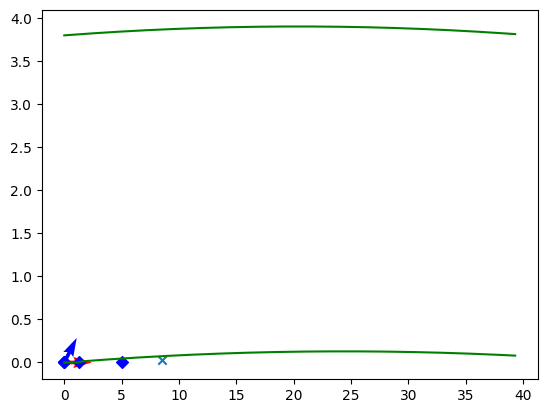

In [33]:
plt.scatter(*ego_pose[0:2], marker='D', color='r')
plt.quiver(*ego_pose[0:2], *ego_pose[3:5], color='r')

for obj in objs_pose:
    if obj[-1] != 0:
        plt.scatter(*obj[0:2], marker='D', color='b')
        plt.quiver(*obj[0:2], *obj[3:5], color='b')
for line in ref_lines:
    if line.any():
        rl_x = line[:,0]
        rl_y = line[:,1]
        plt.plot(rl_x, rl_y, color='g')

plt.scatter(*look_ahead_pt[0:2], marker='x')
    
plt.show()

## utm to bev

In [17]:
import numpy as np

def utm_to_bev(
        pt_utm_array: np.ndarray,
        ego_x_utm: float,
        ego_y_utm: float,
        ego_heading_utm: float
    ) -> np.ndarray:
    """Transform list of UTM points to BEV coordinate.

    Args:
        pt_utm_array (np.ndarray): List of UTM points. [[x, y, heading(Optional)]]
        ego_x_utm (float): Ego car x w.r.t. UTM
        ego_y_utm (float): Ego car y w.r.t. UTM
        ego_heading_utm (float): Ego car heading w.r.t. UTM

    Returns:
        np.ndarray: List of BEV points
    """
    
    def is_heading_provided() -> bool:
        return len(pt_utm_array[0]) > 2

    pt_bev_array = []
    for i in range(len(pt_utm_array)):
        pt_utm_x = pt_utm_array[i][0]
        pt_utm_y = pt_utm_array[i][1]

        pt_x_shifted = pt_utm_x - ego_x_utm
        pt_y_shifted = pt_utm_y - ego_y_utm

        pt_x_rotated = pt_x_shifted * np.cos(ego_heading_utm) \
                        + pt_y_shifted * np.sin(ego_heading_utm)
        pt_y_rotated = - pt_x_shifted * np.sin(ego_heading_utm) \
                        + pt_y_shifted * np.cos(ego_heading_utm)
        
        if is_heading_provided():
            pt_utm_heading = pt_utm_array[i][2]
            pt_heading_rotated = pt_utm_heading - ego_heading_utm
            pt_bev_array.append([pt_x_rotated, pt_y_rotated, pt_heading_rotated])
        else:
            pt_bev_array.append([pt_x_rotated, pt_y_rotated])

    pt_bev_array = np.asarray(pt_bev_array)
    return pt_bev_array

In [ ]:
def rotate_vec_2d(
    vec: np.ndarray,
    radian: float,
) -> np.ndarray:
    """ Rotate a 2D vector clockwise.

    Args:
        vec (np.ndarray): Query 2d vector.
        radian (float): Radian to rotate, in rad.

    Returns:
        np.ndarray: Result 2d vector.
    """

    rotation_matrix = np.array([
        [np.cos(radian), -np.sin(radian)],
        [np.sin(radian), np.cos(radian)]
    ])

    return np.matmul(rotation_matrix, vec)

In [ ]:
num_objs = 3

ego_bev = np.array([0, 0, 0])
objects_bev = objs_pose[0:num_objs,[0,1,2]]
objects_v_bev = objs_pose[0:num_objs,[3, 4]]
# objects_bev = utm_to_bev(objs_pose[0:num_objs,[0,1,2]], *ego_pose[0:3])
# objects_v_bev = utm_to_bev(objs_pose[0:num_objs,[3, 4]], *ego_pose[0:3])

# objects_v_bev = np.array([
#     rotate_vec_2d(obj_v, -ego_pose[2]) for obj_v in objs_pose[0:num_objs,[3, 4]]
# ])
look_ahead_pt_bev = [look_ahead_pt[:-1]], *ego_pose[0:3]
# look_ahead_pt_bev = utm_to_bev([look_ahead_pt[:-1]], *ego_pose[0:3])

In [ ]:
plt.quiver(ego_bev[0], ego_bev[1], ego_pose[3], ego_pose[4], color='r')
plt.scatter(*look_ahead_pt_bev[0], marker='x')
for idx in range(len(objects_bev)):
    plt.quiver(objects_bev[idx][0], objects_bev[idx][1], objects_v_bev[idx][0], objects_v_bev[idx][1], color='b')
for line in ref_lines:
    rl_x = line[:,0]
    rl_y = line[:,1]
    plt.plot(rl_x, rl_y, color='g')
    
plt.show()

In [ ]:
def rotate_vec_2d(
    vec: np.ndarray,
    radian: float,
) -> np.ndarray:
    """ Rotate a 2D vector clockwise.

    Args:
        vec (np.ndarray): Query 2d vector.
        radian (float): Radian to rotate, in rad.

    Returns:
        np.ndarray: Result 2d vector.
    """

    rotation_matrix = np.array([
        [np.cos(radian), -np.sin(radian)],
        [np.sin(radian), np.cos(radian)]
    ])

    return np.matmul(rotation_matrix, vec)

In [ ]:
query_vec = np.array([1,0])
rotated_vec = rotate_vec_2d(query_vec, -np.pi/4)

In [ ]:
plt.scatter(*query_vec, color='r')
plt.scatter(*rotate_vec_2d(query_vec, 6*np.pi/4), color='y')
plt.scatter(*rotate_vec_2d(query_vec, np.pi/4), color='g')
plt.scatter(*rotate_vec_2d(query_vec, -np.pi/4), color='b')
plt.xlim(-1.5, 1.5)
plt.ylim(-1.5, 1.5)
plt.savefig('test.png', format='png')
plt.show()

In [ ]:
def calculate_distance(
    query_point: np.ndarray,
    reference_point: np.ndarray
) -> float:
    """ Calculate distance between two points of any dimension.

    Args:
        query_point (np.ndarray): The query point.
        reference_point (np.ndarray): The reference point.

    Returns:
        float: distance
    """
    return np.linalg.norm(query_point-reference_point)

In [ ]:
observation[0].shape

In [ ]:
selections = observation[0][:, -1].astype(bool)
selections

In [ ]:
observation_filtered = observation[0][selections, :]
observation_filtered.shape

In [ ]:
observation[0]

In [ ]:
distance = np.array([calculate_distance(obj_loc, observation[0][0,0:2]) for obj_loc in observation[0][1:, 0:2]])
distance

In [ ]:
near_selections = distance <= 100
near_selections

In [ ]:
def shuffle_objects(observation: np.ndarray) -> np.ndarray:
    return np.random.shuffle(observation[1:, :])

In [ ]:
observation[0]

In [ ]:
shuffle_objects(observation[0])

In [ ]:
observation[0]

In [ ]:
a = [0, 1, 2, 3, 4, 5, 6, 7]

In [ ]:
a[3:]